In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install numpy h5py matplotlib tqdm


--- Generating 64x64 Dataset ---


Generating 64x64 samples: 100%|██████████| 1200/1200 [00:01<00:00, 649.04it/s]


Successfully generated and saved dataset to 'heat_2d_64.h5'

--- Verifying Data from 'heat_2d_64.h5' ---
Plotting sample index: 0
Verification plot saved to 'verification_plot_64x64.png'


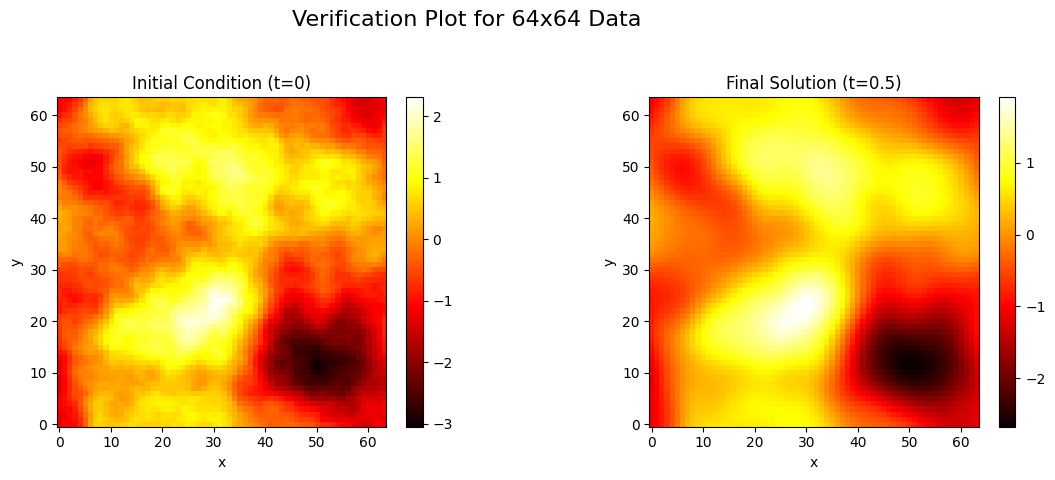


--- Generating 256x256 Dataset ---


Generating 256x256 samples: 100%|██████████| 200/200 [00:01<00:00, 117.64it/s]


Successfully generated and saved dataset to 'heat_2d_256.h5'

--- Verifying Data from 'heat_2d_256.h5' ---
Plotting sample index: 1
Verification plot saved to 'verification_plot_256x256.png'


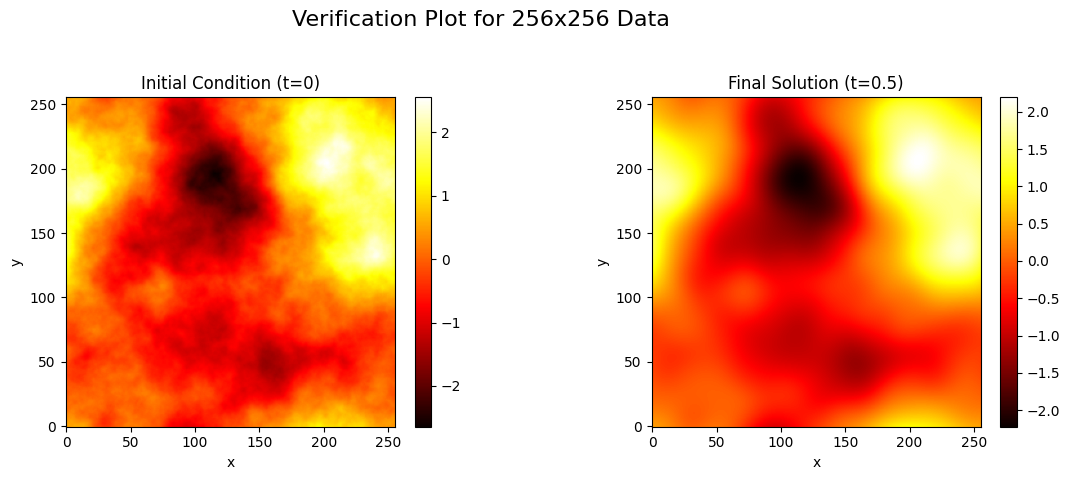

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# --- Helper Function to Generate Initial Conditions ---

def generate_grf(size, alpha=2.0, tau=7.0):
    """
    Generates a Gaussian Random Field (GRF) as an initial condition.
    This creates a smooth, random function which is a good representation
    for many physical phenomena.

    Args:
        size (int): The grid size (e.g., 64 for a 64x64 grid).
        alpha (float): Controls the amplitude of the modes.
        tau (float): Controls the smoothness of the field. Higher is smoother.

    Returns:
        np.ndarray: A 2D array representing the initial condition u_0.
    """
    # Create a grid of wavenumbers
    k_x = np.fft.fftfreq(size, d=1/size)
    k_y = np.fft.fftfreq(size, d=1/size)
    K_x, K_y = np.meshgrid(k_x, k_y)
    K_squared = K_x**2 + K_y**2
    K_squared[0, 0] = 1.0  # Avoid division by zero

    # Generate random phases and amplitudes in Fourier space
    phi = np.random.uniform(0, 2 * np.pi, size=(size, size))
    f_hat = np.exp(1j * phi) * (K_squared)**(-alpha / 2)
    f_hat[0, 0] = 0.0

    # Transform back to real space to get the GRF
    u_0 = np.fft.ifft2(f_hat).real

    # Normalize to have a standard deviation of 1
    u_0 = (u_0 - np.mean(u_0)) / np.std(u_0)

    return u_0

# --- Main Data Generation Function ---

def generate_heat_data(size, num_samples, T, alpha, filepath):
    """
    Generates a dataset for the 2D heat equation using a spectral solver.

    Args:
        size (int): Grid resolution.
        num_samples (int): Number of data pairs to generate.
        T (float): Final time for the simulation.
        alpha (float): Thermal diffusivity constant.
        filepath (str): Path to save the HDF5 file.
    """
    print(f"\n--- Generating {size}x{size} Dataset ---")
    if os.path.exists(filepath):
        print(f"Dataset file '{filepath}' already exists. Skipping generation.")
        return

    # Prepare HDF5 file
    with h5py.File(filepath, 'w') as f:
        # Create datasets to store the input (u0) and output (uT)
        f.create_dataset('u0', (num_samples, size, size), dtype='f4')
        f.create_dataset('uT', (num_samples, size, size), dtype='f4')

        # Store metadata as attributes
        f.attrs['size'] = size
        f.attrs['T'] = T
        f.attrs['alpha'] = alpha
        f.attrs['num_samples'] = num_samples

        # --- The Spectral Solver Logic ---
        # 1. Get wavenumbers
        k_x = np.fft.fftfreq(size, d=1/size)
        k_y = np.fft.fftfreq(size, d=1/size)
        K_x, K_y = np.meshgrid(k_x, k_y)
        K_squared = K_x**2 + K_y**2

        # 2. This is the exact solution to the heat equation in Fourier space
        solution_operator = np.exp(-alpha * K_squared * T)

        # Loop to generate each sample
        for i in tqdm(range(num_samples), desc=f"Generating {size}x{size} samples"):
            # 3. Generate a random initial condition
            u_0 = generate_grf(size)

            # 4. Transform initial condition to Fourier space
            u_0_hat = np.fft.fft2(u_0)

            # 5. Solve for the final state in Fourier space (one simple multiplication)
            u_T_hat = u_0_hat * solution_operator

            # 6. Transform back to real space
            u_T = np.fft.ifft2(u_T_hat).real

            # 7. Save the pair to the HDF5 file
            f['u0'][i, :, :] = u_0
            f['uT'][i, :, :] = u_T

    print(f"Successfully generated and saved dataset to '{filepath}'")

# --- Verification and Plotting Function ---

def verify_data(filepath, sample_index=None):
    """
    Loads a sample from the generated dataset and plots it to ensure
    the data is accurate and makes physical sense.

    Args:
        filepath (str): Path to the HDF5 dataset file.
        sample_index (int, optional): Index of the sample to plot.
                                      If None, a random index is chosen.
    """
    print(f"\n--- Verifying Data from '{filepath}' ---")
    try:
        with h5py.File(filepath, 'r') as f:
            num_samples = f.attrs['num_samples']
            if sample_index is None:
                sample_index = np.random.randint(0, num_samples)

            print(f"Plotting sample index: {sample_index}")

            u_0 = f['u0'][sample_index]
            u_T = f['uT'][sample_index]
            T = f.attrs['T']
            size = f.attrs['size']

            # Create the plot
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            fig.suptitle(f"Verification Plot for {size}x{size} Data", fontsize=16)

            # Plot Initial Condition
            im1 = axes[0].imshow(u_0, cmap='hot', origin='lower')
            axes[0].set_title(f"Initial Condition (t=0)")
            axes[0].set_xlabel("x")
            axes[0].set_ylabel("y")
            fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

            # Plot Final Solution
            im2 = axes[1].imshow(u_T, cmap='hot', origin='lower')
            axes[1].set_title(f"Final Solution (t={T})")
            axes[1].set_xlabel("x")
            axes[1].set_ylabel("y")
            fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            
            # Save the plot
            plot_filename = f"verification_plot_{size}x{size}.png"
            plt.savefig(plot_filename)
            print(f"Verification plot saved to '{plot_filename}'")
            plt.show()

    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
    except Exception as e:
        print(f"An error occurred during verification: {e}")

# --- Main Execution Block ---

if __name__ == "__main__":
    # --- Parameters for 64x64 Dataset ---
    SIZE_64 = 64
    NUM_SAMPLES_64 = 1200  # 1000 for training, 200 for testing
    FILEPATH_64 = 'heat_2d_64.h5'

    # --- Parameters for 256x256 Dataset ---
    SIZE_256 = 256
    NUM_SAMPLES_256 = 200  # For testing/evaluation
    FILEPATH_256 = 'heat_2d_256.h5'
    
    # --- Shared Physics Parameters ---
    FINAL_TIME = 0.5
    DIFFUSIVITY = 0.05

    # --- Generate, then verify the 64x64 dataset ---
    generate_heat_data(
        size=SIZE_64,
        num_samples=NUM_SAMPLES_64,
        T=FINAL_TIME,
        alpha=DIFFUSIVITY,
        filepath=FILEPATH_64
    )
    verify_data(FILEPATH_64, sample_index=0)

    # --- Generate, then verify the 256x256 dataset ---
    generate_heat_data(
        size=SIZE_256,
        num_samples=NUM_SAMPLES_256,
        T=FINAL_TIME,
        alpha=DIFFUSIVITY,
        filepath=FILEPATH_256
    )
    verify_data(FILEPATH_256, sample_index=1)

Epoch 1 Training: 100%|██████████| 50/50 [00:01<00:00, 32.18it/s, loss=0.0842]


Epoch 1 - Training Loss: 0.481794


Epoch 2 Training: 100%|██████████| 50/50 [00:01<00:00, 33.07it/s, loss=0.0173]


Epoch 2 - Training Loss: 0.031046


Epoch 3 Training: 100%|██████████| 50/50 [00:01<00:00, 33.76it/s, loss=0.0153]


Epoch 3 - Training Loss: 0.014804


Epoch 4 Training: 100%|██████████| 50/50 [00:01<00:00, 34.07it/s, loss=0.0103]


Epoch 4 - Training Loss: 0.012056


Epoch 5 Training: 100%|██████████| 50/50 [00:01<00:00, 33.75it/s, loss=0.0118]


Epoch 5 - Training Loss: 0.011891


Epoch 6 Training: 100%|██████████| 50/50 [00:01<00:00, 33.77it/s, loss=0.00961]


Epoch 6 - Training Loss: 0.010552


Epoch 7 Training: 100%|██████████| 50/50 [00:01<00:00, 33.95it/s, loss=0.00875]


Epoch 7 - Training Loss: 0.010176


Epoch 8 Training: 100%|██████████| 50/50 [00:01<00:00, 34.19it/s, loss=0.0218] 


Epoch 8 - Training Loss: 0.011033


Epoch 9 Training: 100%|██████████| 50/50 [00:01<00:00, 34.06it/s, loss=0.0151]


Epoch 9 - Training Loss: 0.015228


Epoch 10 Training: 100%|██████████| 50/50 [00:01<00:00, 33.01it/s, loss=0.0101] 


Epoch 10 - Training Loss: 0.012832

--- Training Complete. Starting Final Evaluation. ---


Evaluating on 64x64: 100%|██████████| 10/10 [00:00<00:00, 50.55it/s]

Average Test Loss (64x64): 0.008802



Evaluating on 256x256 (Super-Resolution): 100%|██████████| 10/10 [00:00<00:00, 11.00it/s]


Average Test Loss (256x256 Super-Resolution): 0.009033
Prediction plot saved to 'fno_prediction_64x64.png'


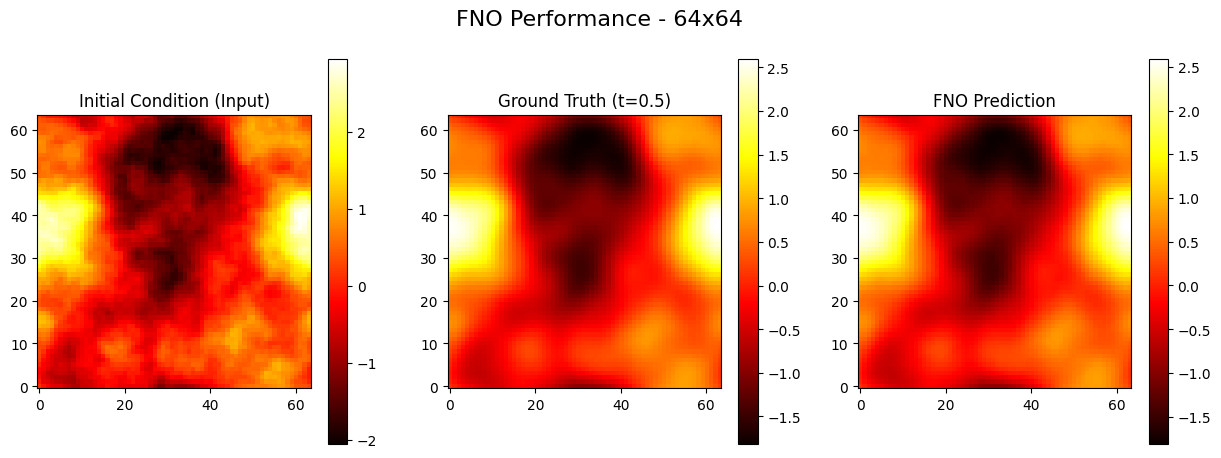

Prediction plot saved to 'fno_prediction_256x256_Super_Resolution.png'


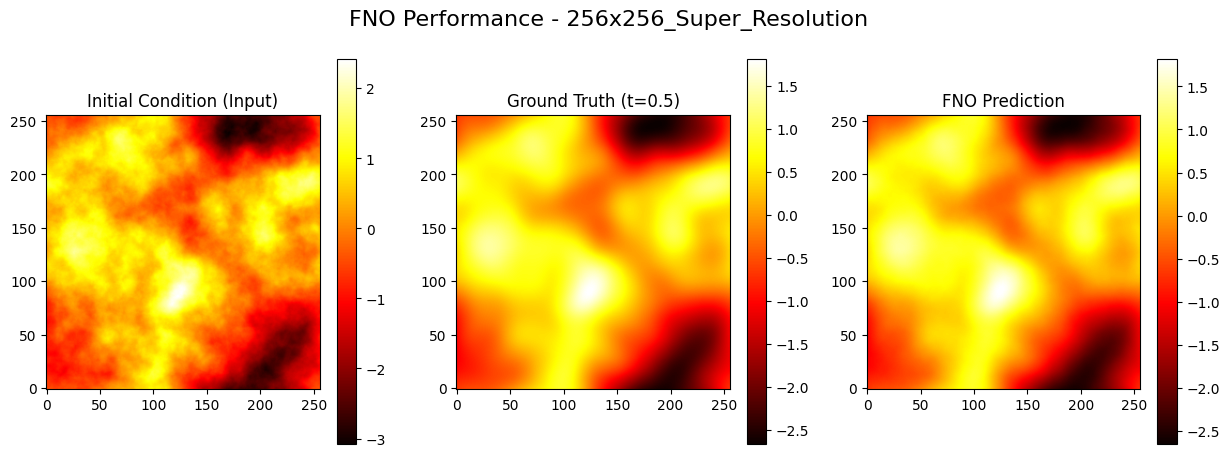

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import h5py
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# --- Configuration ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- 1. FNO Model Definition (Building from Scratch) ---

class SpectralConv2d(nn.Module):
    """
    2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
    This is the core building block of the FNO.
    """
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to keep in the first dimension
        self.modes2 = modes2  # Number of Fourier modes to keep in the second dimension

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = torch.einsum("bixy,ioxy->boxy", x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = torch.einsum("bixy,ioxy->boxy", x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    """
    The full Fourier Neural Operator model.
    It stacks Fourier layers and uses a final projection layer.
    """
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        
        # Input features are u(x,y,t=0) + grid coordinates (x,y)
        self.p = nn.Linear(3, self.width)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.conv4 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w4 = nn.Conv2d(self.width, self.width, 1)
        self.q = nn.Linear(self.width, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.p(x)
        x = x.permute(0, 3, 1, 2)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv4(x)
        x2 = self.w4(x)
        x = x1 + x2

        x = x.permute(0, 2, 3, 1)
        x = self.q(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

# --- 2. Data Loading ---

class HeatDataset(Dataset):
    """
    Custom Dataset class for loading the HDF5 data.
    """
    def __init__(self, filepath, n_train, n_test, train=True):
        self.filepath = filepath
        self.n_train = n_train
        self.n_test = n_test
        self.train = train
        with h5py.File(self.filepath, 'r') as f:
            self.size = f.attrs['size']
            self.total_samples = f.attrs['num_samples']
        
    def __len__(self):
        return self.n_train if self.train else self.n_test

    def __getitem__(self, idx):
        # For testing, we offset the index to get the unseen data
        if not self.train:
            idx += self.n_train
            
        with h5py.File(self.filepath, 'r') as f:
            u0 = f['u0'][idx, :, :]
            uT = f['uT'][idx, :, :]

        u0_tensor = torch.tensor(u0, dtype=torch.float).unsqueeze(-1)
        uT_tensor = torch.tensor(uT, dtype=torch.float).unsqueeze(-1)
        
        return u0_tensor, uT_tensor

# --- 3. Loss Function ---

class LpLoss(object):
    """
    Lp loss function, used for comparing the relative error.
    """
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()
        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def rel(self, x, y):
        num_examples = x.size()[0]
        diff_norms = torch.norm(x.reshape(num_examples, -1) - y.reshape(num_examples, -1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples, -1), self.p, 1)
        return torch.mean(diff_norms / y_norms)

    def __call__(self, x, y):
        return self.rel(x, y)

# --- 4. Training and Evaluation ---

def train_model(model, train_loader, optimizer, loss_fn, epoch):
    model.train()
    total_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} Training")
    for x, y in pbar:
        x, y = x.to(DEVICE), y.to(DEVICE)
        
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out.squeeze(), y.squeeze())
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})
        
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Training Loss: {avg_loss:.6f}")
    return avg_loss

def evaluate_model(model, test_loader_64, test_loader_256, loss_fn):
    model.eval()
    with torch.no_grad():
        # --- Evaluation on 64x64 data ---
        test_loss_64 = 0
        for x, y in tqdm(test_loader_64, desc="Evaluating on 64x64"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            test_loss_64 += loss_fn(out.squeeze(), y.squeeze()).item()
        avg_test_loss_64 = test_loss_64 / len(test_loader_64)
        print(f"Average Test Loss (64x64): {avg_test_loss_64:.6f}")

        # --- Evaluation on 256x256 data (Zero-Shot Super-Resolution) ---
        test_loss_256 = 0
        for x, y in tqdm(test_loader_256, desc="Evaluating on 256x256 (Super-Resolution)"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x) # The FNO handles different resolutions naturally
            test_loss_256 += loss_fn(out.squeeze(), y.squeeze()).item()
        avg_test_loss_256 = test_loss_256 / len(test_loader_256)
        print(f"Average Test Loss (256x256 Super-Resolution): {avg_test_loss_256:.6f}")

        # --- Visualize one example from each test set ---
        visualize_results(model, test_loader_64, "64x64")
        visualize_results(model, test_loader_256, "256x256_Super_Resolution")

def visualize_results(model, loader, name):
    # Get a single batch from the loader
    x, y_true = next(iter(loader))
    x, y_true = x.to(DEVICE), y_true.to(DEVICE)
    
    # Get the model prediction for the batch
    y_pred = model(x)

    # --- FIX STARTS HERE ---
    # Select the very first sample from the batch for plotting
    x_sample = x[0].squeeze().cpu().numpy()
    y_true_sample = y_true[0].squeeze().cpu().numpy()
    y_pred_sample = y_pred[0].squeeze().cpu().numpy()
    # --- FIX ENDS HERE ---

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"FNO Performance - {name}", fontsize=16)

    # Use the single samples for plotting
    im1 = axes[0].imshow(x_sample, cmap='hot', origin='lower')
    axes[0].set_title("Initial Condition (Input)")
    fig.colorbar(im1, ax=axes[0])
    
    im2 = axes[1].imshow(y_true_sample, cmap='hot', origin='lower')
    axes[1].set_title("Ground Truth (t=0.5)")
    fig.colorbar(im2, ax=axes[1])
    
    im3 = axes[2].imshow(y_pred_sample, cmap='hot', origin='lower')
    axes[2].set_title("FNO Prediction")
    fig.colorbar(im3, ax=axes[2])
    
    plot_filename = f"fno_prediction_{name}.png"
    plt.savefig(plot_filename)
    print(f"Prediction plot saved to '{plot_filename}'")
    plt.show()

# --- 5. Main Execution Block ---

if __name__ == "__main__":
    # --- Hyperparameters ---
    MODES = 12
    WIDTH = 20
    BATCH_SIZE = 20
    EPOCHS = 10 # Increase for better results
    LEARNING_RATE = 0.001

    # --- Data Paths (assuming Kaggle output directory) ---
    # Adjust this path if your data is elsewhere
    DATA_PATH_64 = 'heat_2d_64.h5'
    DATA_PATH_256 = 'heat_2d_256.h5'

    # --- Check if data exists ---
    if not os.path.exists(DATA_PATH_64) or not os.path.exists(DATA_PATH_256):
        print("Error: Dataset files not found. Please run the data generation script first.")
    else:
        # --- Setup DataLoaders ---
        # We train on 1000 samples and test on 200 from the 64x64 dataset
        train_dataset_64 = HeatDataset(DATA_PATH_64, n_train=1000, n_test=200, train=True)
        test_dataset_64 = HeatDataset(DATA_PATH_64, n_train=1000, n_test=200, train=False)
        train_loader_64 = DataLoader(train_dataset_64, batch_size=BATCH_SIZE, shuffle=True)
        test_loader_64 = DataLoader(test_dataset_64, batch_size=BATCH_SIZE, shuffle=False)
        
        # The 256x256 dataset is only for testing super-resolution
        test_dataset_256 = HeatDataset(DATA_PATH_256, n_train=0, n_test=200, train=False)
        test_loader_256 = DataLoader(test_dataset_256, batch_size=BATCH_SIZE, shuffle=False)

        # --- Setup Model and Optimizer ---
        model = FNO2d(modes1=MODES, modes2=MODES, width=WIDTH).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
        loss_fn = LpLoss()

        # --- Training Loop ---
        for epoch in range(EPOCHS):
            train_model(model, train_loader_64, optimizer, loss_fn, epoch)
            
        print("\n--- Training Complete. Starting Final Evaluation. ---")
        
        # --- Final Evaluation ---
        evaluate_model(model, test_loader_64, test_loader_256, loss_fn)